# INTERMEDIATE LEVEL TASK: SPAM EMAIL CLASSIFICATION
# Description: Build a classification model to predict whether an email is spam or not based on its content.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Load the Dataset
data = pd.read_csv("spam.csv", encoding='latin-1')
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
# Drop unnecessary columns
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.columns = ['label', 'message']

In [5]:
data.isna().sum()

label      0
message    0
dtype: int64

In [6]:
data.duplicated().sum()

403

In [7]:
# Remove duplicates
data.drop_duplicates(keep='first',inplace=True)

In [8]:
data.shape

(5169, 2)

In [9]:
data.describe().T

,count,unique,top,freq
label,5169,2,ham,4516
message,5169,5169,"Go until jurong point, crazy.. Available only ...",1


In [10]:
# Calculate the counts of spam and non-spam emails in the dataset
email_label_counts = data['label'].value_counts()
email_label_counts

label
ham     4516
spam     653
Name: count, dtype: int64

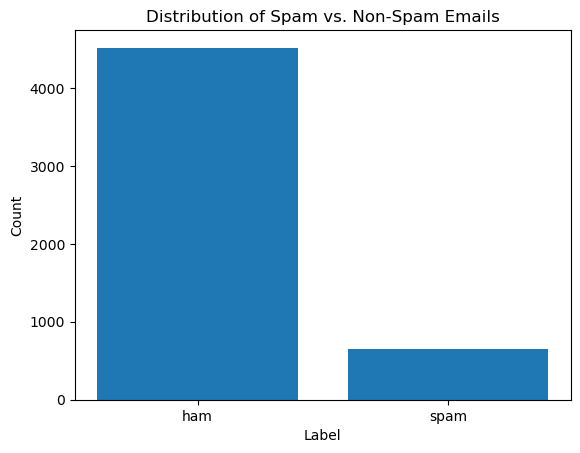

In [11]:
# Plot a bar chart to visualize the distribution of spam vs. non-spam emails
plt.bar(email_label_counts.index, email_label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Spam vs. Non-Spam Emails')
plt.show()

In [12]:
# Map the label column to numeric values (1 for 'spam', 0 for 'ham')
data['label'] = data['label'].map({'spam': 1, 'ham': 0})
data

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [13]:
# Tokenization: Split each message into a list of tokens
data['tokens'] = data['message'].apply(word_tokenize)

In [14]:
# Removing Stop Words: Filter out common stop words from the tokens
stop_words = set(stopwords.words('english'))
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

In [15]:
# Lemmatization: Reduce each word in the tokens to its base or dictionary form
lemmatizer = WordNetLemmatizer()
data['tokens'] = data['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [16]:
# Concatenate the tokens back into a single string
data['message'] = data['tokens'].apply(lambda x: ' '.join(x))
data

,label,message,tokens
0,0,"Go jurong point , crazy .. Available bugis n g...","[Go, jurong, point, ,, crazy, .., Available, b..."
1,0,Ok lar ... Joking wif u oni ...,"[Ok, lar, ..., Joking, wif, u, oni, ...]"
2,1,Free entry 2 wkly comp win FA Cup final tkts 2...,"[Free, entry, 2, wkly, comp, win, FA, Cup, fin..."
3,0,U dun say early hor ... U c already say ...,"[U, dun, say, early, hor, ..., U, c, already, ..."
4,0,"Nah n't think go usf , life around though","[Nah, n't, think, go, usf, ,, life, around, th..."
...,...,...,...
5567,1,2nd time tried 2 contact u. U å£750 Pound priz...,"[2nd, time, tried, 2, contact, u., U, å£750, P..."
5568,0,Ì_ b going esplanade fr home ?,"[Ì_, b, going, esplanade, fr, home, ?]"
5569,0,"Pity , * mood . ... suggestion ?","[Pity, ,, *, mood, ., ..., suggestion, ?]"
5570,0,guy bitching acted like 'd interested buying s...,"[guy, bitching, acted, like, 'd, interested, b..."


In [17]:
# Splitting the data into training and testing sets
X = data["message"]
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Vectorize the preprocessed text data using CountVectorizer
# Fit and transform the training data to create the vocabulary and token counts
# Transform the testing data using the same vocabulary as the training data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [19]:
# Transform the token count matrices into TF-IDF weighted matrices
# Fit and transform the training data to compute TF-IDF weights
# Transform the testing data using the same TF-IDF weights as the training data
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [20]:
# Support Vector Machine Model
svm_model = SVC()

# Train the Support Vector Machine model using the TF-IDF weighted training data
svm_model.fit(X_train, y_train)

# Evaluate the model's accuracy on the TF-IDF weighted testing data
svm_score = svm_model.score(X_test, y_test)

# Print the accuracy of the Support Vector Machine model
print(f"Support Vector Machine Model Accuracy: {svm_score:0.1%}")

Support Vector Machine Model Accuracy: 98.1%


In [21]:
# Logistic Regression Model
logistic_model = LogisticRegression()

# Train the Logistic Regression model using the TF-IDF weighted training data
logistic_model.fit(X_train, y_train)

# Evaluate the model's accuracy on the TF-IDF weighted testing data
logistic_score = logistic_model.score(X_test, y_test)

# Print the accuracy of the Logistic Regression model
print("Logistic Regression Model Accuracy: {:.1%}".format(logistic_score))

Logistic Regression Model Accuracy: 96.1%


In [22]:
# Make predictions using the trained Logistic Regression and Support Vector Machine models
logistic_predictions = logistic_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

In [23]:
# Generate confusion matrices for the Logistic Regression and Support Vector Machine models
logistic_confusion_matrix = confusion_matrix(y_test, logistic_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)

In [24]:
plt.figure(figsize=(15, 10))
rows = 1
columns = 2

<Figure size 1500x1000 with 0 Axes>

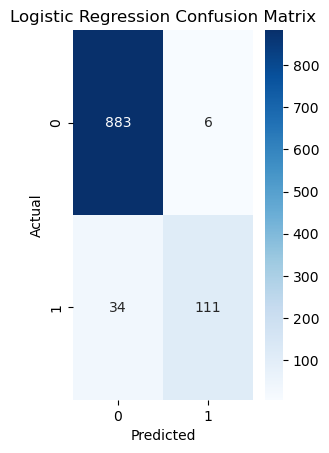

In [25]:
# Plotting Logistic Regression Confusion Matrix
plt.subplot(rows, columns, 1)
sns.heatmap(logistic_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

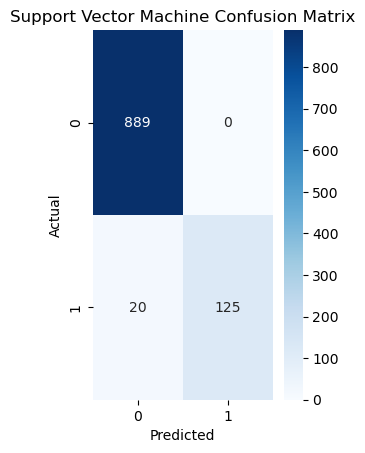

In [26]:
# Plotting Support Vector Machine Confusion Matrix
plt.subplot(rows, columns, 2)
sns.heatmap(svm_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Support Vector Machine Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
# Print the classification report for the Logistic Regression model
print("Logistic Regression Model Evaluation:")
print(classification_report(y_test, logistic_predictions))

# Print the classification report for the Support Vector Machine model
print("Support Vector Machine Model Evaluation:")
print(classification_report(y_test, svm_predictions))

Logistic Regression Model Evaluation:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       889
           1       0.95      0.77      0.85       145

    accuracy                           0.96      1034
   macro avg       0.96      0.88      0.91      1034
weighted avg       0.96      0.96      0.96      1034

Support Vector Machine Model Evaluation:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       1.00      0.86      0.93       145

    accuracy                           0.98      1034
   macro avg       0.99      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034

